### Pontos importantes

Antes de entrar na criação em si, vamos entender alguns pontos que vão ajudar na compreenção da análise do modelo.

* Accuracy: É a medida de desempenho que pega a proporção dos acertos pelo total de itens verificados.
> $$ \frac{TP+FP}{TP+TN+FP+FN} $$

* Precision: É a medida que pega a proporção de observações positivas previstas corretamente, pelo total de observação previstas corretamente.
> $$\frac{TP}{TP+FP}$$

* Recall: É a medida da razão das observações positivas preditas corretamente para todas as medidas da observação da classe real.
> $$\frac{TP}{TP+FN}$$

* F1 Score: É a medida que calcula a média harmônica entre a Precision e a Recall(Sensibility).
> $$\frac{2*Recall*Precision}{Recall + Precision}$$

## Criação de um modelo baseline
Para a criação de um modelo inicial para nos basearmos, iremos seguir algumas etapas.

* Feature Engineering
* Modeling
* Performance Analysis


In [45]:
# importando bibliotecas
import pandas as pd
from asd import dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from asd import metrics

%matplotlib inline

In [3]:
# Criando dataframe
df = dataset.autism()
df.set_index('id',inplace = True)
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
id,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,0,1,1,0,1,0,0,...,m,Others,no,no,Jordan,no,5,4-11 years,Parent,NO
2,1,1,0,0,1,1,0,1,0,0,...,m,Middle Eastern,no,no,Jordan,no,5,4-11 years,Parent,NO
3,1,1,0,0,0,1,1,1,0,0,...,m,?,no,no,Jordan,yes,5,4-11 years,?,NO
4,0,1,0,0,1,1,0,0,0,1,...,f,?,yes,no,Jordan,no,4,4-11 years,?,NO
5,1,1,1,1,1,1,1,1,1,1,...,m,Others,yes,no,United States,no,10,4-11 years,Parent,YES


In [35]:
# Função de plotagem da matriz de confusão
def plot_confusion_matrix(y_test,result,cmap = plt.cm.Blues):
    # Confusion matrix
    cm = confusion_matrix(y_test,result)
    classe = unique_labels(y_test,result)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classe, yticklabels=classe,
           title= 'Matriz de confusão',
           ylabel='Rótulo real',
           xlabel='Rótulo previsto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    #fmt = '.2f' if _ else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


### 1. Feature Engineering

Nessa etapa será selecionado as features que vamos utilizar no modelo baseline.

In [4]:
# Selecionando colunas com os traços comportamentais.
columns = ['A{}_Score'.format(i) for i in range(1,11)]

# Separando em variáveis preditoras X e alvo da nossa predição Y
X = df[columns]
Y = df['Class/ASD']

# Para melhor entendimento do dataset, iremos renomear os valores de Y
Y = Y.replace({'NO':'Sem_Autismo','YES':'Autismo'})

### 2. Modeling

Nessa etapa aplicaremos o modelo que foi selecionado e com isso a contrução das predições do nosso modelo baseline.

* Modelo selecionado: Decision Tree
* Motivo: Fácil compreensão.

In [5]:
# Criação do modelo

baseline = tree.DecisionTreeClassifier()

Nessa parte testarei duas técnicas para evitar que o modelo se "acostume" com o nosso banco de dados.

* Separando em treino e teste
* Validação cruzada

#### Treino e Teste

In [6]:
# Separando em treino e teste
x_train,x_test,y_train,y_test = train_test_split(X,Y,
                                                 test_size = 0.4,
                                                 random_state = 40)

# Treinando o modelo
test1 = baseline.fit(x_train,y_train)

results = test1.predict(x_test)


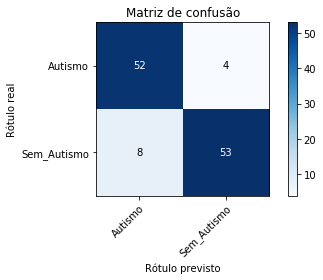

In [47]:
plot_confusion_matrix(y_test,results)
#metrics.confusion_metrics(y_test,results)
plt.show()

#### K-Fold Corss Validation

In [ ]:
# Em andamento